In [1]:
# clean up outputs from warnings
import warnings
warnings.filterwarnings("ignore")

# required imports 
import numpy as np
import pandas as pd
import networkx as nx
import scraper
import matplotlib.pyplot as plt
import powerlaw
import scipy.stats as sps
from itertools import chain

We begin by fetching the first 3 levels of the `Wikipedia vital articles` category using our own `scraper`. The resulting initial graph is also saved for later use. We used the `page_class` node attribute to separate the classes of `user` and `article`. Nodes $a$ and $b$ from the `article` class were connected by edge $a \rightarrow b$ if the content of the Wikipedia article corresponding to $a$ contained a link to article $b$. Similarly, directed edges $u \rightarrow a$ were added between article $a$ and all user nodes $u$ found by parsing the corresponding talk page.

In [8]:
category_titles = [
    "Category:Wikipedia_level-1_vital_articles",
    "Category:Wikipedia_level-2_vital_articles",
    "Category:Wikipedia_level-3_vital_articles",
]
page_graph, infos  = await scraper.scrape_wiki(category_titles)
nx.write_graphml(page_graph, "wikigraph.graphml")

Next we remove bot users. Our list of bot user names was compiled by filtering nodes of type `user` containing the substring `bot`. Since Wikipedia doesn't have an official bot name convention we verified the resulting user list manually. We then compute basic network properties on the remaining graph.

In [2]:
# read saved initial graph
graph = nx.read_graphml("wikigraph.graphml")

# remove bot users from graph
bot_names = ["User:Community Tech bot", "User:PrimeBOT", "User:InternetArchiveBot", "User:AnomieBOT", "User:RMCD bot", "User:Cyberbot II", "User:CommonsNotificationBot",
"User:LinkBot", "User:FairuseBot", "User:BetacommandBot", "User:Legobot", "User:DumZiBoT"]
graph.remove_nodes_from(bot_names)

# Print network properties
print(f"Number of nodes: {graph.number_of_nodes()}")
print(f"Number of edges: {graph.number_of_edges()}")
print(f"Average clustering coefficient: {nx.average_clustering(graph)}")
print(f"Number of weakly connected components: {len(list(nx.weakly_connected_components(graph)))}")
degrees_dict = {"Node": dict(graph.degree).keys(), "Total Degree": dict(graph.degree).values(), "In Degree": dict(graph.in_degree).values(), "Out Degree": dict(graph.out_degree).values()}
degrees_view = pd.DataFrame(degrees_dict).set_index("Node")
print("Top 5 nodes with largest in-degree:")
degrees_view.sort_values(["Total Degree"], ascending=False).head(5)

Number of nodes: 80580
Number of edges: 176368
Average clustering coefficient: 0.04063680702604195
Number of weakly connected components: 1
Top 5 nodes with largest in-degree:


,Total Degree,In Degree,Out Degree
Node,,,
United States,2458,2276,182
Jesus,1942,1903,39
India,1835,1652,183
Climate change,1800,1777,23
Israel,1696,1636,60


Degree distirbution explanations. The resulting network is scale free.

In [12]:
# Plotting degree distributions

In [3]:
graph_u = graph.to_undirected()

# filter for user names and article titles in the graph
nodes_by_class = dict(graph.nodes(data="page_class"))
user_names = [node for node in nodes_by_class if nodes_by_class[node] == "user"]
article_titles = [node for node in nodes_by_class if nodes_by_class[node] == "article"]

users_graph = graph_u.subgraph(user_names)
articles_graph = graph_u.subgraph(article_titles)
print(f"Number of article pages: {articles_graph.number_of_nodes()}")
print(f"Connections between article pages: {articles_graph.number_of_edges()}")
print(f"Connections between user pages: {users_graph.number_of_edges()}")

# returns true if the edge with endpoints u and v is between an article and a user node
def isDifferentClass(graph, u, v):
    ua = graph.nodes[u]["page_class"] == "user" and graph.nodes[v]["page_class"] == "article"
    au = graph.nodes[u]["page_class"] == "article" and graph.nodes[v]["page_class"] == "user"
    return ua or au

print(f"Connections between users and articles: {len([(u,v) for (u, v) in graph_u.edges() if isDifferentClass(graph_u, u, v)])}")

Number of article pages: 1000
Connections between article pages: 15713
Connections between user pages: 0
Connections between users and articles: 159057


## Weighted graph of articles

We create a graph where the nodes are the articles two nodes are connected by an edge of weight $w$ if exactly $w$ users contributed to both.

In [15]:
def add_weighted_edges(graph, source, node_type, frontier_type, frontier_key):
    for node in list(graph.nodes):
        related = {}
        frontier = set(n for n in source.neighbors(node) if source.nodes[n]["page_class"] == frontier_type)
        graph.nodes[node][frontier_key] = len(frontier)
        for f in frontier:
            neighbor_nodes = list( n for n in source.neighbors(f) if source.nodes[n]["page_class"] == node_type)
            for n in neighbor_nodes:
                if n != node:
                    if n in related:
                        related[n] += 1
                    else:
                        related[n] = 1
        graph.add_weighted_edges_from([(node, r, related[r]) for r in related])

In [20]:
common_editors = nx.Graph()
common_editors.add_nodes_from(article_titles)
add_weighted_edges(common_editors, graph_u, "article", "user", "editors_no")


Basic analysis on the resulting graph. Slight change in top 5 nodes by degree is probably due to users that only contributed to one article being filtered out.

In [5]:
common_editors = nx.read_graphml("weighted_article_connections.graphml")

print(f"Number of nodes: {common_editors.number_of_nodes()}")
print(f"Number of edges: {common_editors.number_of_edges()}")
print(f"Number of connected components: {nx.number_connected_components(common_editors)}")
print(f"Average clustering coefficient: {nx.average_clustering(common_editors)}")
edge_weight_dict = nx.get_edge_attributes(common_editors, "weight")
editors_dict = common_editors.nodes(data="editors_no")
editors_view = pd.DataFrame(editors_dict, columns=["Node", "Editors"]).set_index("Node")
print(f"Maximum editors: {editors_view.Editors.max()}")
print(f"Average editors: {editors_view.Editors.mean()}")
print(f"Median editors: {editors_view.Editors.median()}")

print("\nTop 5 nodes by overall number of editors:")
editors_view.sort_values(["Editors"], ascending=False).head(5)


Number of nodes: 1000
Number of edges: 242107
Number of connected components: 3
Average clustering coefficient: 0.708347877885475
Maximum editors: 2221
Average editors: 159.057
Median editors: 86.0

Top 5 nodes by overall number of editors:


,Editors
Node,
United States,2221
Jesus,1879
Climate change,1768
Israel,1612
India,1601


In [8]:
degree_a = [editors_dict[edge[0]] for edge in edge_weight_dict.keys()]
degree_b = [editors_dict[edge[1]] for edge in edge_weight_dict.keys()]
edges = [f"{u}, {v}" for (u, v) in edge_weight_dict.keys()]
shared_user_df = pd.DataFrame({"Edge": edges, "Weight": edge_weight_dict.values(), "Editors A": degree_a,
                              "Editors B": degree_b}).set_index("Edge")
print(f"Maximum edge weight: {shared_user_df.Weight.max()}")
print(f"Average edge weight: {shared_user_df.Weight.mean()}")
print(f"Median edge weight: {shared_user_df.Weight.median()}")
print("\nTop 10 node pairs by overall number of shared editors:")
most_raw_connected = shared_user_df.sort_values(["Weight"], ascending=False).head(10)
most_raw_connected

Maximum edge weight: 221
Average edge weight: 3.3285695993920044
Median edge weight: 2.0

Top 10 node pairs by overall number of shared editors:


,Weight,Editors A,Editors B
Edge,,,
"Christianity, Jesus",221,985,1879
"Israel, Jerusalem",206,1612,637
"Islam, Muhammad",203,1127,1396
"Jesus, United States",178,1879,2221
"Jesus, Muhammad",176,1879,1396
"China, Taiwan",174,842,937
"Adolf Hitler, Jesus",168,1535,1879
"United Kingdom, United States",163,1188,2221
"Israel, United States",147,1612,2221


Now we normalize the weights by the number of editors for each individual article. In this way the highest relative weight is assigned to the article where the biggest percentage of the editor group contributed to both.

In [23]:
for (u, v, data) in common_editors.edges(data=True):
    raw_weight = data["weight"]
    common_editors[u][v]["relative_weight"] = raw_weight * 2 / (editors_dict[u] + editors_dict[v])

# save resulting graph for future analysis
nx.write_graphml(common_editors, "weighted_article_connections.graphml")

In [6]:

relative_edge_weight_dict = nx.get_edge_attributes(common_editors, "relative_weight")
degree_a = [editors_dict[edge[0]] for edge in relative_edge_weight_dict.keys()]
degree_b = [editors_dict[edge[1]] for edge in relative_edge_weight_dict.keys()]
edges = [f"{u}, {v}" for (u, v) in relative_edge_weight_dict.keys()]
rel_weight_df = pd.DataFrame({"Edge": edges, "Weight": relative_edge_weight_dict.values(), "Editors A": degree_a,
                              "Editors B": degree_b}).set_index("Edge")
# print(f"Average clustering coefficient (relative weights): {nx.average_clustering(common_editors, weight='relative_weight')}")
print(f"Max edge weight: {rel_weight_df.Weight.max()}")
print(f"Average edge weight: {rel_weight_df.Weight.mean()}")
print(f"Median edge weight: {rel_weight_df.Weight.median()}")

print("\nTop 10 node pairs by ratio of shared editors:")
rel_weight_df.sort_values(["Weight"], ascending=False).head(10)

Max edge weight: 0.2962962962962963
Average edge weight: 0.015857352552814043
Median edge weight: 0.012658227848101266

Top 10 node pairs by ratio of shared editors:


,Weight,Editors A,Editors B
Edge,,,
"Mahayana, Theravada",0.296296,46,62
"Early modern period, Post-classical history",0.291667,20,28
"Inorganic chemistry, Organic chemistry",0.238095,12,30
"Natural number, Real number",0.235294,96,91
"Complex number, Function (mathematics)",0.226950,148,134
"Number, Natural number",0.222222,75,96
"Avicenna, Al-Khwarizmi",0.213333,175,200
"Jupiter, Neptune",0.212560,247,167
"Jupiter, Venus",0.212121,247,281


As we can see, articles from semantically related topics that are less popular tend to have a higher shared editor percentage. This means that less popular pages have a niche of contributing users who choose to specialize according to their specific area of interest / expertise. Now let's see the shared user percentages for the highest ranking edges by overall number of editors.

In [9]:
top_by_count = rel_weight_df.loc[most_raw_connected.index]
no_higher = len(rel_weight_df.loc[rel_weight_df['Weight'] > top_by_count['Weight'].max()])
all_above_min = len(rel_weight_df.loc[rel_weight_df['Weight'] > top_by_count['Weight'].min()])
print(f"Number of edges with higher weights: {no_higher}")
print(f"Below edges are in the top {all_above_min / len(rel_weight_df) * 100:.2}%")
print("\nRelative shared editors for the top 10 edges by shared editor number:")
top_by_count

Number of edges with higher weights: 20
Below edges are in the top 0.56%

Relative shared editors for the top 10 edges by shared editor number:


,Weight,Editors A,Editors B
Edge,,,
"Christianity, Jesus",0.154330,985,1879
"Israel, Jerusalem",0.183193,1612,637
"Islam, Muhammad",0.160920,1127,1396
"Jesus, United States",0.086829,1879,2221
"Jesus, Muhammad",0.107481,1879,1396
"China, Taiwan",0.195616,842,937
"Adolf Hitler, Jesus",0.098418,1535,1879
"United Kingdom, United States",0.095629,1188,2221
"Israel, United States",0.076702,1612,2221


This shows that the more popular topics are still ranked very high overall. While there are a few surprising connections (e.g. Adolf Hitler and Jesus), most of the node pairs we see here are semantically related. The high editor count indicates that these topics are more universal, popular and some gain edits from being more controversial. Now let's see the 10 lowest rankied topics.

In [30]:
print("Bottom 10 node pairs by number of shared editors:")
shared_user_df.sort_values(["Weight"], ascending=True).head(10)

Bottom 10 node pairs by number of shared editors:


,Weight,Editors A,Editors B
Edge,,,
"Yangtze, Zheng He",1,44,68
"Aristotle, Orbit",1,229,56
"Neolithic Revolution, Emmy Noether",1,58,77
"Aristotle, Emmy Noether",1,229,77
"Neolithic Revolution, Nutrition",1,58,101
"Neolithic Revolution, Photon",1,58,173
"Egypt, Triangle",1,342,74
"Aristotle, Martial arts",1,229,94
"Aristotle, Jewellery",1,229,44


# Weighted graph of users

In [10]:
lim = 0.2
rel_connected_edges = rel_weight_df[rel_weight_df.Weight >= lim].index
rel_connected_articles = set(chain.from_iterable([edge.split(", ") for edge in rel_connected_edges]))
removable_articles = set(articles_graph.nodes) - rel_connected_articles

In [11]:
small_articles_graph = graph_u.copy()
small_articles_graph.remove_nodes_from(removable_articles)

# remove users not connected to our focus articles
removable_users = set()
for user in user_names:
    for article in rel_connected_articles:
        if small_articles_graph.has_edge(user, article):
            break
    else:
        removable_users.add(user)
small_articles_graph.remove_nodes_from(removable_users)

In [23]:
common_articles = nx.Graph()
common_articles.add_nodes_from(set(user_names) - removable_users)
add_weighted_edges(common_articles, small_articles_graph, "user", "article", "articles_no")

edited_articles_dict = common_articles.nodes(data="articles_no")
for (u, v, data) in common_articles.edges(data=True):
    raw_weight = data["weight"]
    common_articles[u][v]["relative_weight"] = raw_weight * 2 / (edited_articles_dict[u] + edited_articles_dict[v])

nx.write_graphml(common_articles, "weighted_user_connections.graphml")

In [24]:
common_articles = nx.read_graphml("weighted_user_connections.graphml")
edited_articles_dict = common_articles.nodes(data="articles_no")
edge_weight_dict = nx.get_edge_attributes(common_articles, "weight")
articles_a = [edited_articles_dict[edge[0]] for edge in edge_weight_dict.keys()]
articles_b = [edited_articles_dict[edge[1]] for edge in edge_weight_dict.keys()]
edges = [f"{u}, {v}" for (u, v) in edge_weight_dict.keys()]
edge_weight_df = pd.DataFrame({"Edge": edges, "Weight": edge_weight_dict.values(), "Articles A": articles_a,
                               "Articles B": articles_b}).set_index("Edge")
print(f"Max edge weight: {edge_weight_df.Weight.max()}")
print(f"Average edge weight: {edge_weight_df.Weight.mean()}")
print(f"Median edge weight: {edge_weight_df.Weight.median()}")

Max edge weight: 7
Average edge weight: 1.034163589219769
Median edge weight: 1.0


In [26]:
print(f"Number of nodes: {common_articles.number_of_nodes()}")
print(f"Number of edges: {common_articles.number_of_edges()}")

Number of nodes: 2439
Number of edges: 318175


In [27]:
print(f"Average clustering coefficient: {nx.average_clustering(common_articles)}")

Average clustering coefficient: 0.9240174907436006


In [28]:
edge_weight_df.sort_values(["Weight"], ascending=False).head(10)

,Weight,Articles A,Articles B
Edge,,,
"User:D.Lazard, User:Dmcq",7,8,7
"User:Sławomir Biały, User:Dmcq",7,7,7
"User:D.Lazard, User:CBM",7,8,7
"User:D.Lazard, User:Sławomir Biały",7,8,7
"User:D.Lazard, User:Wcherowi",7,8,7
"User:D.Lazard, User:Salix alba",6,8,6
"User:Sławomir Biały, User:Paul August",6,7,6
"User:Oleg Alexandrov, User:CBM",6,6,7
"User:Wcherowi, User:Dmcq",6,7,7


In [29]:
common_articles.remove_nodes_from([node for node in common_articles.nodes if common_articles.degree(node) < 1])
louvain_partition_raw = nx.community.louvain_communities(common_articles)
print("Weights are common user numbers:")
print( "number of communities found: ", len(louvain_partition_raw))
print("modularity of louvain partitions: ", nx.community.modularity(common_articles, louvain_partition_raw))

print("---------------------------------")


louvain_partition_rel = nx.community.louvain_communities(common_articles, weight="relative_weight")
print("Weights are relative user numbers:")
print( "number of communities found: ", len(louvain_partition_rel))
print("modularity of louvain partitions: ", nx.community.modularity(common_articles, louvain_partition_rel))

Weights are common user numbers:
number of communities found:  7
modularity of louvain partitions:  0.6080072050973521
---------------------------------
Weights are relative user numbers:
number of communities found:  10
modularity of louvain partitions:  0.6123337949977752


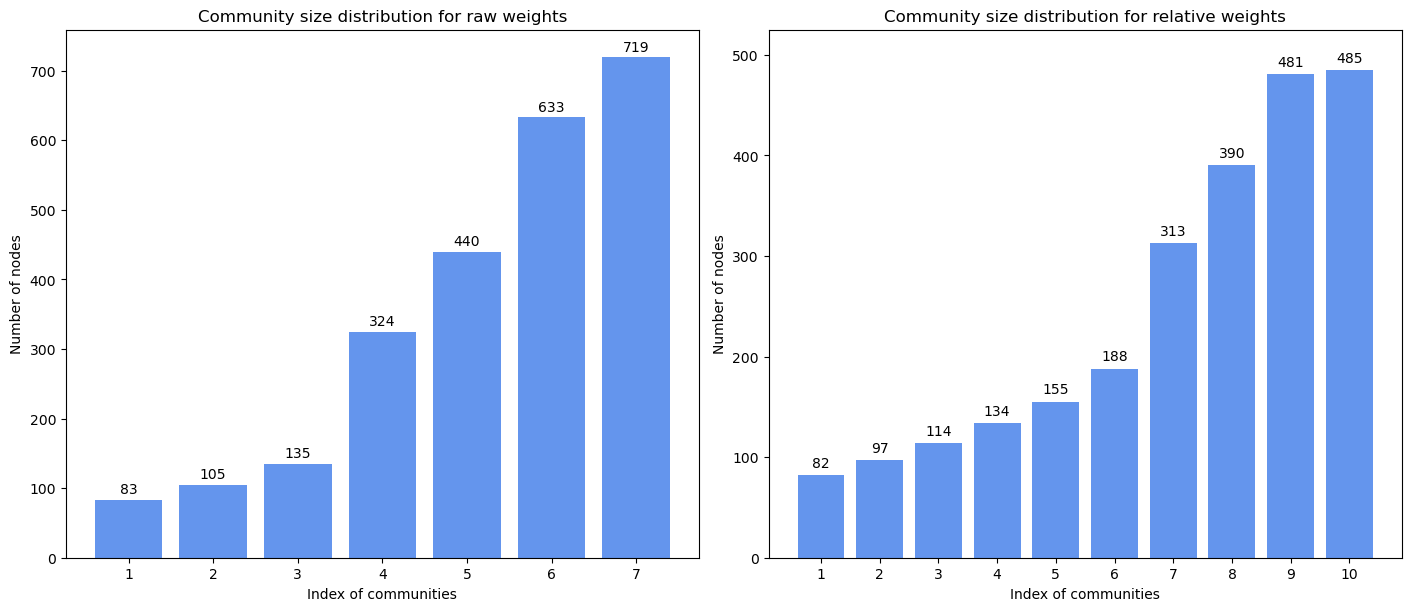

In [30]:
titles = ["Community size distribution for raw weights", "Community size distribution for relative weights"]
partitions = [louvain_partition_raw, louvain_partition_rel]
fig, ax = plt.subplots(1, 2, figsize=(14, 6), layout="constrained")
for idx, (titles, partition) in enumerate(zip(titles, partitions)):
    sorted_size_communities = sorted([len(comm) for comm in partition])
    ax[idx].bar([x for x in range(1,len(partition)+1)], sorted_size_communities, color="cornflowerblue")
    ax[idx].set_title(label=titles)
    ax[idx].set_xlabel(xlabel="Index of communities")
    ax[idx].set_ylabel(ylabel="Number of nodes")
    ax[idx].set_xticks([x for x in range (1,len(partition)+1)])
    min_c = sorted_size_communities[0]
    max_c = sorted_size_communities[-1]
    ax[idx].set_ylim((0, max_c + 40))

    rects = ax[idx].patches
    labels = [size for size in sorted_size_communities]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax[idx].text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom")
    
plt.show()
